# Курсовой проект 
# Black Friday

Задание для курсового проекта

Метрика: R2 - коэффициент детерминации (sklearn.metrics.r2_score)

Сдача проекта:

1. Сдать проект нужно в течение 7 дней после окончания последнего вебинара.
2. Прислать в раздел Задания Урока 10 ("Вебинар. Консультация по итоговому проекту") ссылку на ноутбук в github или public kaggle notebook.
3. Необходимо получить R2 > 0.6 на Private Leaderboard.

### Загрузка библиотек

In [1472]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import r2_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.ensemble import BaggingRegressor
from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN, KMeans, AgglomerativeClustering

import pickle

from sklearn.model_selection import train_test_split

In [1473]:
import warnings
warnings.filterwarnings('ignore')

#### Пути к директориям

In [1474]:
TRAIN_DATASET_PATH = './train.csv'
TEST_DATASET_PATH = './test.csv'

### Загрузка данных

In [1475]:
df_train = pd.read_csv(TRAIN_DATASET_PATH)
df_test = pd.read_csv(TEST_DATASET_PATH)
print('Data is loaded!')

Data is loaded!


In [1476]:
print(f'Train: {df_train.shape[0]} строк и {df_train.shape[1]} признаков')
print(f'Test: {df_test.shape[0]} строк и {df_test.shape[1]} признаков')
df_train.shape[1] - 1 == df_test.shape[1]

Train: 80000 строк и 12 признаков
Test: 20000 строк и 11 признаков


True

### Описание данных

* **User_ID** - идентификационный номер покупателя
* **Product_ID** - идентификационный номер товара
* **Gender** - пол покупателя
* **Age** - возраст покупателя
* **Occupation** - род деятельности покупателя
* **City_Category** - город проживания
* **Stay_In_Current_City_Years** - как долго покупатель живет в этом городе
* **Marital_Status** - семейное положение покупателя
* **Product_Category_1** - категория товара 1
* **Product_Category_2** - категория товара 2
* **Product_Category_3** - категория товара 3
* **Purchase** - сумма покупок

In [1477]:
df_train.columns

Index(['User_ID', 'Product_ID', 'Gender', 'Age', 'Occupation', 'City_Category',
       'Stay_In_Current_City_Years', 'Marital_Status', 'Product_Category_1',
       'Product_Category_2', 'Product_Category_3', 'Purchase'],
      dtype='object')

###  Оптимизация занимаемой памяти

In [1478]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [1479]:
df_train = reduce_mem_usage(df_train)

Memory usage of dataframe is 7.32 MB
Memory usage after optimization is: 1.91 MB
Decreased by 74.0%


### Определим признаки

In [1480]:
feature_names = ['User_ID', 'Product_ID', 'Gender', 'Age', 'Occupation', 'City_Category',
       'Stay_In_Current_City_Years', 'Marital_Status', 'Product_Category_1',
       'Product_Category_2', 'Product_Category_3']

target_name = 'Purchase'

In [1481]:
df_train.dtypes

User_ID                          int32
Product_ID                    category
Gender                        category
Age                           category
Occupation                        int8
City_Category                 category
Stay_In_Current_City_Years    category
Marital_Status                    int8
Product_Category_1                int8
Product_Category_2             float32
Product_Category_3             float32
Purchase                         int16
dtype: object

## Изучение признаков Feature Exploring

### **Целевая переменная -  target**

In [1482]:
df_train[target_name].describe()

count    80000.000000
mean      9243.933162
std       5021.298356
min         12.000000
25%       5679.750000
50%       8039.000000
75%      12046.000000
max      23961.000000
Name: Purchase, dtype: float64

In [1483]:
target_mean = df_train[target_name].mean()

In [1484]:
target_median = df_train[target_name].median()

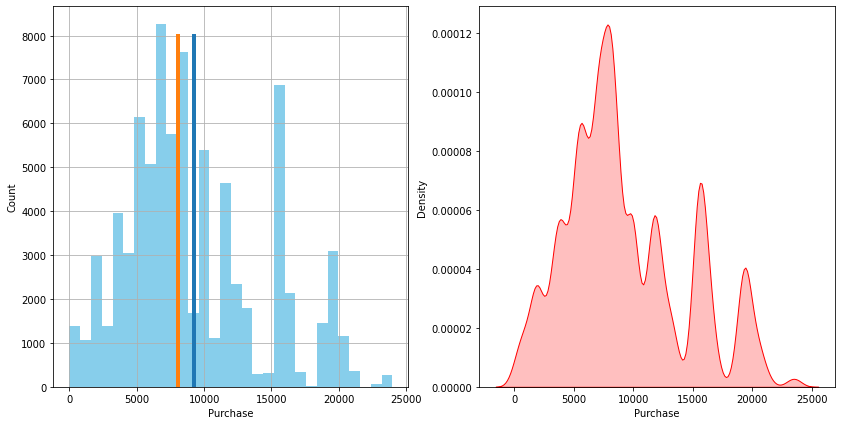

In [1485]:
plt.figure(figsize = (14,7))

plt.subplot(121)
df_train[target_name].hist(bins = 30, color = 'skyblue')
y = np.linspace(0, 8000, 10)
plt.plot([target_mean]*10, y, label='mean',  linewidth=4)
plt.plot([target_median]*10, y, label='median',  linewidth=4)
plt.xlabel('Purchase')
plt.ylabel('Count')

plt.subplot(122)
sns.kdeplot(df_train[target_name], shade = True, color = 'red')

plt.show()

Распределение целевой переменной нельзя назвать нормальным, данные имеют очень широкие неоднородный разброс.

In [1486]:
#Есть сильный неоднородный разброс после значения 14000. Посчитаем количество объектов наблюдений.
df_train.loc[df_train['Purchase'] > 14000, 'Purchase'].count()

16123

In [1487]:
#Количество наблюдений достаточно большое, чтобы от него избавляться.
#df_train = df_train[df_train['Purchase'] < 14000]

In [1488]:
df_train.loc[df_train['Purchase'] > 20000, 'Purchase'].count()

1822

In [1489]:
#df_train = df_train[df_train['Purchase'] < 20000]

In [1490]:
#Изучим слишком маленькие суммы покупкок
df_train.loc[df_train[target_name] < 100, target_name].sum()

8783

In [1491]:
#df_train = df_train[df_train['Purchase'] > 100]

Попробовав разные варианты работы с целевой переменной, наиболее удачным вариантом оказалось не убирать из нее ни хвост, ни начало диапазона значаний, что обуславливается спецификой задачи и распространенностью Черной пятницы. Люди могут совершать покупку как на небольшие суммы, пользуясь приятной акцией, так и совершать крупные покупки, в том числе техника, или дорогая мебель для того, чтобы обустроить жилье.

Покупок на сумму свыше 20 000 мало, но я не решаюсь называть это выбросом, т.к. речь идет о покупках и действительно позволить себе сделать крупную покупку может далеко не каждый, и, вероятно, кто-то дождался распродажи купить выгоднее что-то дорогое

 ### **Исследуемый датасет состоит из категориальных признаков. Изучим их подробнее**

#### Gender

In [1492]:
gender_counts = df_train['Gender'].value_counts()
gender_counts

M    60068
F    19932
Name: Gender, dtype: int64

Количество покупателей мужчин почти в 3 раза превосходит количество покупателей женщин
Если при изучении значимости признаков окажется, что пол оказывает большое влияние на целевую переменную, необходимо с осторожностью обрабатывать спрос покупателей-женщин, т.к. их доля существенно меньше и ошибки будут иметь бОльший вес

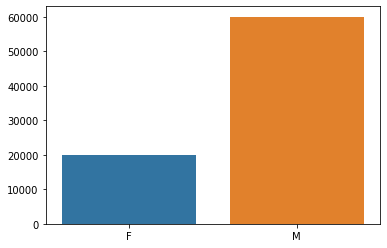

In [1493]:
sns.barplot(gender_counts.index, gender_counts.values)
plt.show()

#### Age

В данном признаке целесообразно определить минимум и максимум для понимания диапазона взраста покупателей

In [1494]:
# Определим количество возрастных групп в наблюдениях:
df_train['Age'].nunique()

7

In [1495]:
# Посмотрим заброс покупателей по возрастным группам:
age_counts = df_train['Age'].value_counts()
age_counts

26-35    32067
36-45    16025
18-25    14286
46-50     6777
51-55     5555
55+       3110
0-17      2180
Name: Age, dtype: int64

Наибольшее количество покупок приходится на возрастную группу 26-35 лет. Можно предположить, что опираясь именно на этот возраст, можно выявить основные тендеции
Самые низкие показатели у покупателей до 18 лет и у покупателей старше 55.

Можно допустить, что небольшая доля покупок у покупалетей до 18 лет связана с ограничениями на площадке продажи

Посмотрим нагляднее:

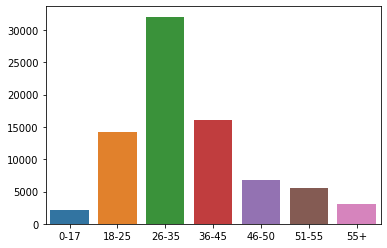

In [1496]:
sns.barplot(age_counts.index, age_counts.values)
plt.show()

In [1497]:
#Изучим соотношение мужчин и жещин в каждой возрастной группе
df_train.groupby(['Age', 'Gender'])['User_ID'].count()

Age    Gender
0-17   F           779
       M          1401
18-25  F          3634
       M         10652
26-35  F          7526
       M         24541
36-45  F          3943
       M         12082
46-50  F          1917
       M          4860
51-55  F          1393
       M          4162
55+    F           740
       M          2370
Name: User_ID, dtype: int64

Более всего бросается в глаза разница в группе 26-35 лет и старше 55 лет

#### Occupation

In [1498]:
df_train['Occupation'].unique()

array([ 6,  7,  3,  0,  4,  1, 20, 18, 14, 17, 16, 10, 12,  2, 15, 19,  9,
       13,  5, 11,  8], dtype=int8)

In [1499]:
df_train['Occupation'].nunique()

21

In [1500]:
occupation_counts = df_train['Occupation'].value_counts()
occupation_counts

4     10443
0     10188
7      8474
1      6921
17     5815
20     4887
12     4559
14     4030
2      3849
16     3724
6      2902
3      2598
10     1876
5      1824
15     1712
11     1706
19     1258
13     1132
18     1011
9       857
8       234
Name: Occupation, dtype: int64

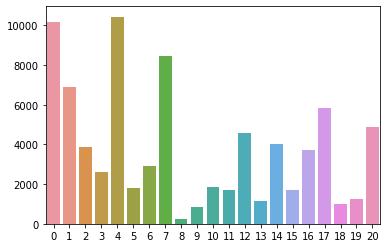

In [1501]:
sns.barplot(occupation_counts.index, occupation_counts.values)
plt.show()

Большая часть покупок приходится на покупателей, работающих в сфере деятельности 0, 1 и 7.

Совсем мало покупок совершают покупатели категории 8 

#### City_Category

In [1502]:
city_counts = df_train['City_Category'].value_counts()
city_counts

B    33767
C    24778
A    21455
Name: City_Category, dtype: int64

<AxesSubplot:>

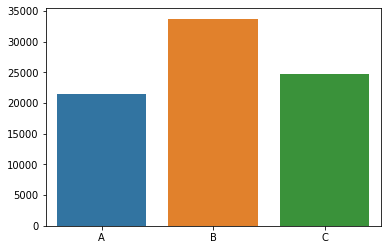

In [1503]:
sns.barplot(city_counts.index, city_counts.values)

Изучаются покупатели в 3 городах, большая часть которых проживает в городе B.
Распределение по городам в целом можно назвать равномерным 

#### Stay_In_Current_City_Years 

In [1504]:
staying_counts = df_train['Stay_In_Current_City_Years'].value_counts()
staying_counts

1     28287
2     14830
3     13853
4+    12250
0     10780
Name: Stay_In_Current_City_Years, dtype: int64

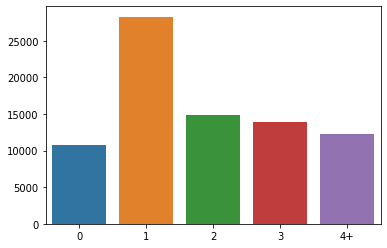

In [1505]:
sns.barplot(staying_counts.index, staying_counts.values)
plt.show()

Наибольшая доля покупателей - проживащие в городе примерно 1 год

Наименьшая у только прибывших, что логично.

In [1506]:
city_group = df_train.groupby(['Stay_In_Current_City_Years', 'City_Category'])['User_ID'].count()
city_group

Stay_In_Current_City_Years  City_Category
0                           A                 3472
                            B                 4220
                            C                 3088
1                           A                 7170
                            B                12204
                            C                 8913
2                           A                 3949
                            B                 6065
                            C                 4816
3                           A                 3638
                            B                 6210
                            C                 4005
4+                          A                 3226
                            B                 5068
                            C                 3956
Name: User_ID, dtype: int64

In [1507]:
#sns.barplot()

#### Marital_Status  

In [1508]:
marital_counts = df_train['Marital_Status'].value_counts()

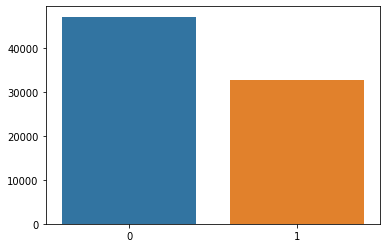

In [1509]:
sns.barplot(marital_counts.index, marital_counts.values)
plt.show()

Сильного разброса между людьми,  находящимися в браке и не в браке нет. 

In [1510]:
df_train.groupby(['Age', 'Marital_Status'])['User_ID'].count()

Age    Marital_Status
0-17   0                  2180
       1                     0
18-25  0                 11234
       1                  3052
26-35  0                 19572
       1                 12495
36-45  0                  9695
       1                  6330
46-50  0                  1871
       1                  4906
51-55  0                  1581
       1                  3974
55+    0                  1116
       1                  1994
Name: User_ID, dtype: int64

В группах до 45 лет большинство покупок делают люди, не находящиеся в браке и с каждой группой разница сокращается. 
После 46 лет доля покупателей в браке существенно превышает долю неженатых. Вероятно, в данном регионе достаточно поздний возраст вступления в брак

До 18 лет вступивших в брак нет - выбросов в данном случае не обнаружено

#### Признаки Product_Category_1, 2 и 3 

Признаки обозначают категории товаров покупателей, детально разбирать каждую категории нецелесообразно

In [1511]:
df_train['Product_Category_1'].unique()

array([ 8,  5,  1,  2,  6, 11,  3,  4,  7, 18, 15, 20, 10, 16, 13, 12, 19,
       14,  9, 17], dtype=int8)

In [1512]:
df_train['Product_Category_1'].nunique()

20

In [1513]:
df_train['Product_Category_2'].unique()

array([14.,  6., 15., 12., nan,  5.,  8., 17., 13., 16., 10., 11.,  2.,
        4.,  9., 18.,  3.,  7.], dtype=float32)

In [1514]:
df_train['Product_Category_2'].nunique()

17

In [1515]:
df_train['Product_Category_3'].unique()

array([nan, 16., 15., 17., 13.,  8., 12.,  5., 18.,  9., 14.,  6.,  3.,
       11., 10.,  4.], dtype=float32)

In [1516]:
df_train['Product_Category_3'].nunique()

15

Наибольшее количество позиций в Product_Category_1.
В Product_Category 2 и 3 одно из значений - nan.
Дополнительно поработаем с ним при обработке пропусков

## Обработка признаков  - Feature engineering 

In [1517]:
df_train.dtypes

User_ID                          int32
Product_ID                    category
Gender                        category
Age                           category
Occupation                        int8
City_Category                 category
Stay_In_Current_City_Years    category
Marital_Status                    int8
Product_Category_1                int8
Product_Category_2             float32
Product_Category_3             float32
Purchase                         int16
dtype: object

В результате обработки данных необходимо, чтобы признаки для обучения модели были в числовых типах данных (int, float)

Важно корректно обработать категориальные признаки - перевести их в дамми, в категории или закодировать через самих себя.

Признак Product_ID является категориальным и было бы наиболее удобным в данной задаче вариантом - перекодировать его через самого себя (например, значениями, полученными в value_counts). 

Однако, изучив датасет подробнее, становится очевидно, что использование линейных моделей в данном случае не будет иметь смысла, будем использовать модели, основанные на деревьях решений, а значит масштаб также не будет важен. Можно рассмотреть вариант не кодирования данного признака, а его видеоизменения из строковых значений в числовые - этот способ хорошо показал себя в модели.

In [1518]:
df_train.isnull().sum()

User_ID                           0
Product_ID                        0
Gender                            0
Age                               0
Occupation                        0
City_Category                     0
Stay_In_Current_City_Years        0
Marital_Status                    0
Product_Category_1                0
Product_Category_2            25108
Product_Category_3            55669
Purchase                          0
dtype: int64

В датасете 2 признака с пропусками (с большим их количеством!) - Product_Category_2 , Product_Category_3. **Изучим их подробнее**

In [1519]:
df_train.loc[df_train['Product_Category_2'].isnull(), 'Product_ID'].value_counts()

P00255842    187
P00031042    186
P00278642    163
P00258742    135
P00371644    132
            ... 
P00168942      0
P00168742      0
P00168342      0
P00167942      0
P0099942       0
Name: Product_ID, Length: 3256, dtype: int64

Проверим гипотезу, что признаки Product_Category_1-3 - подкатегории признака Product_ID и каждому значению категории Product_ID соответствует одно общее значение каждого из признаков Product_Category_1-3

In [1520]:
df_train['Product_ID'].value_counts().head(15)

P00265242    272
P00025442    225
P00112142    224
P00058042    221
P00110742    220
P00057642    214
P00184942    210
P00237542    205
P00145042    204
P00010742    204
P00102642    201
P00117942    200
P00110942    199
P00148642    197
P00046742    197
Name: Product_ID, dtype: int64

In [1521]:
# возьмем выборочно несколько значений Product_ID 
df_train.loc[df_train['Product_ID'] == 'P00148642', ['Product_ID', 'Product_Category_1', 'Product_Category_2', 
                                                     'Product_Category_3']]

,Product_ID,Product_Category_1,Product_Category_2,Product_Category_3
12,P00148642,6,10.0,13.0
44,P00148642,6,10.0,13.0
570,P00148642,6,10.0,13.0
970,P00148642,6,10.0,13.0
991,P00148642,6,10.0,13.0
...,...,...,...,...
78456,P00148642,6,10.0,13.0
78688,P00148642,6,10.0,13.0
79722,P00148642,6,10.0,13.0
79811,P00148642,6,10.0,13.0


In [1522]:
df_train.loc[df_train['Product_ID'] == 'P00025442', ['Product_ID', 'Product_Category_1', 'Product_Category_2', 
                                                     'Product_Category_3']] 

,Product_ID,Product_Category_1,Product_Category_2,Product_Category_3
117,P00025442,1,2.0,9.0
269,P00025442,1,2.0,9.0
477,P00025442,1,2.0,9.0
1275,P00025442,1,2.0,9.0
1386,P00025442,1,2.0,9.0
...,...,...,...,...
78805,P00025442,1,2.0,9.0
78816,P00025442,1,2.0,9.0
78912,P00025442,1,2.0,9.0
79057,P00025442,1,2.0,9.0


In [1523]:
df_train.loc[df_train['Product_ID'] == 'P00117942', ['Product_ID', 'Product_Category_1', 'Product_Category_2', 
                                                     'Product_Category_3']]

,Product_ID,Product_Category_1,Product_Category_2,Product_Category_3
412,P00117942,5,15.0,NaN
635,P00117942,5,15.0,NaN
1206,P00117942,5,15.0,NaN
1659,P00117942,5,15.0,NaN
1958,P00117942,5,15.0,NaN
...,...,...,...,...
78108,P00117942,5,15.0,NaN
78389,P00117942,5,15.0,NaN
78761,P00117942,5,15.0,NaN
79340,P00117942,5,15.0,NaN


Предполагаю, что гипотеза верна и признаки Product_Category_1-3 - своего рода подкатегории признака Product_ID:

**проверим гипотезу 2** : Все ли значения признака 'Product_Category_2', соответствующие признаку 'Product_ID', пусты
если гипотеза не подтвердится, можно найти непропущенные значения и заполнить ими пропуски, соответствующие этому Product_ID

Предполагаю, что 2 гипотеза также верна. В таком случае, возможно, пропуски можно заполнить **любым**  значением, главное чтобы значения, соответствующие признаку Product_ID были одинаковы. Однако утверждать однозначно это нельзя

Важно внимательно подойти к заполнению пропусков в данном датасете (признаки Product_Category_2 & 3) из-за большого их количества (Product_Category_3 более 50% ). Были протестированы варианты заполенения: 

* нулями
* моделью, обученной на признаках Product_ID, Product_Category_1

Заполнение нулями показалось мне в данном случае логичным, однако результаты модели получились ниже, возможно потому что заполняя пропуски значениями, подобранными моделью-  формируется своего рода новый признак, который сильнее выделяет объекты друг от друга.

## Изучение взаимосвязи признаков

### Построение матрицы корреляций

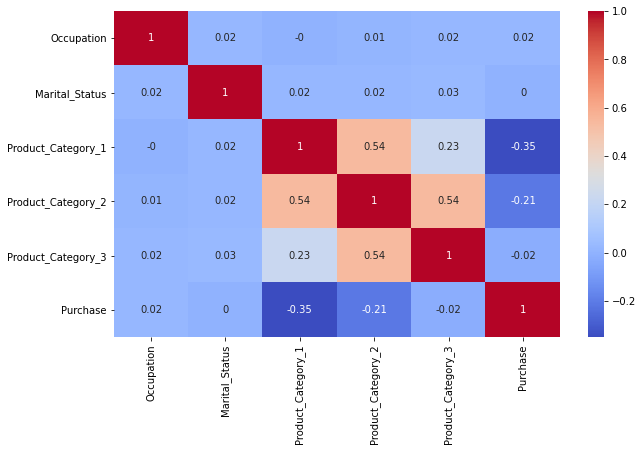

In [1524]:
df_train_for_corr = df_train.copy()
df_train_for_corr.drop('User_ID', axis = 1, inplace = True)
corr_matrix = df_train_for_corr.corr()
corr_matrix = np.round(corr_matrix, 2)
plt.figure(figsize = (10,6))
sns.heatmap(corr_matrix, annot = True, cmap = 'coolwarm')
plt.show()

**Корреляция с целевой переменной в данном конкретном проекте не является наиболее объективной и адекватной оценкой. Т. к. признаки являются категориальными, их линейная связь в общем-то бесполезна для оценки и исследования**

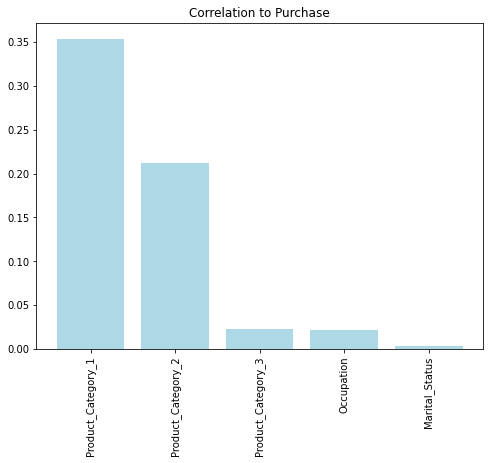

In [1525]:
corr_matrix = df_train_for_corr.corrwith(df_train['Purchase'])
corr_matrix = df_train_for_corr.loc[:, df_train_for_corr.columns != 'Purchase'].corrwith(df_train_for_corr['Purchase']).abs().sort_values(ascending=False)
plt.figure(figsize = (8, 6))
plt.bar(corr_matrix.index, corr_matrix.values, color = 'lightblue')
plt.title('Correlation to Purchase')
plt.xticks(rotation='vertical')
plt.show()

###  Анализ зависимости таргета от признаков

Изучим влияние отдельных признаков на целевую переменную, распределение целевой переменной на основании признаков

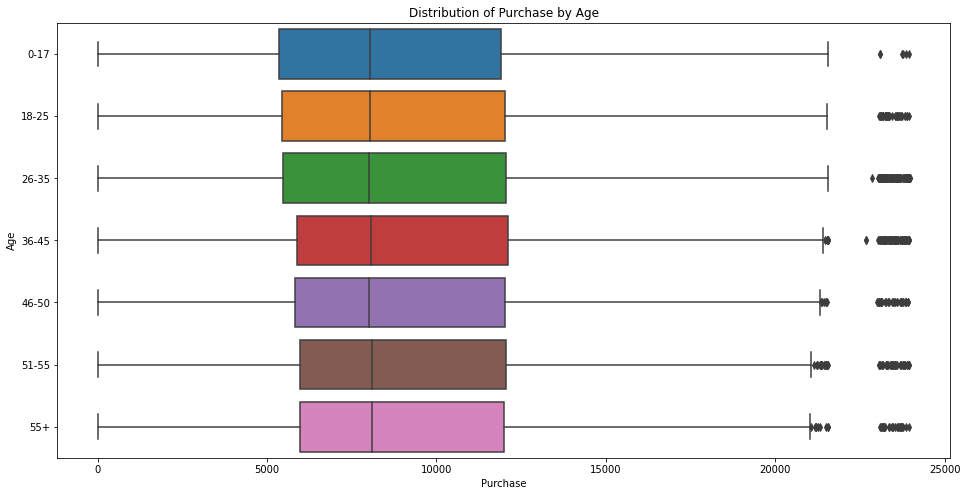

In [1526]:
plt.figure(figsize=(16, 8))

sns.boxplot(df_train['Purchase'], df_train['Age'], whis=1.5)

plt.xlabel('Purchase')
plt.ylabel('Age')
plt.title('Distribution of Purchase by Age')
plt.show()

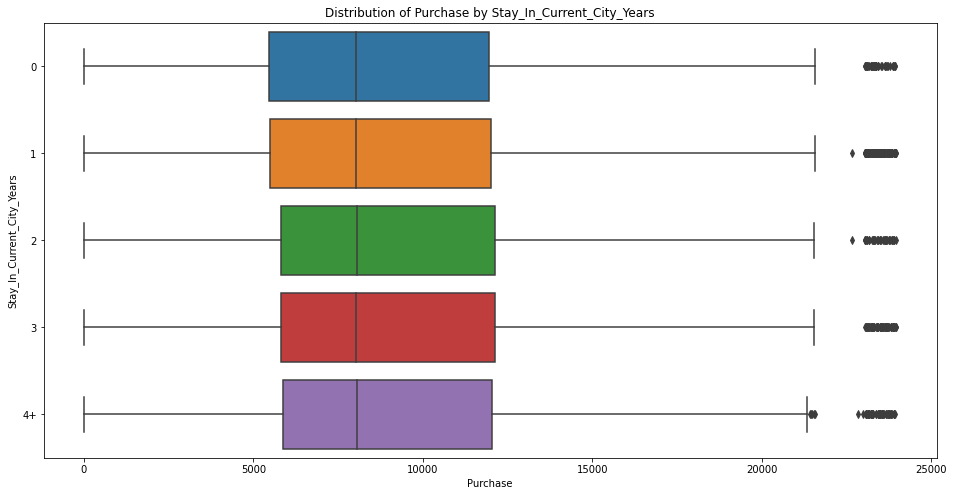

In [1527]:
plt.figure(figsize=(16, 8))

sns.boxplot(df_train['Purchase'], df_train['Stay_In_Current_City_Years'], whis=1.5)

plt.xlabel('Purchase')
plt.ylabel('Stay_In_Current_City_Years')
plt.title('Distribution of Purchase by Stay_In_Current_City_Years')
plt.show()

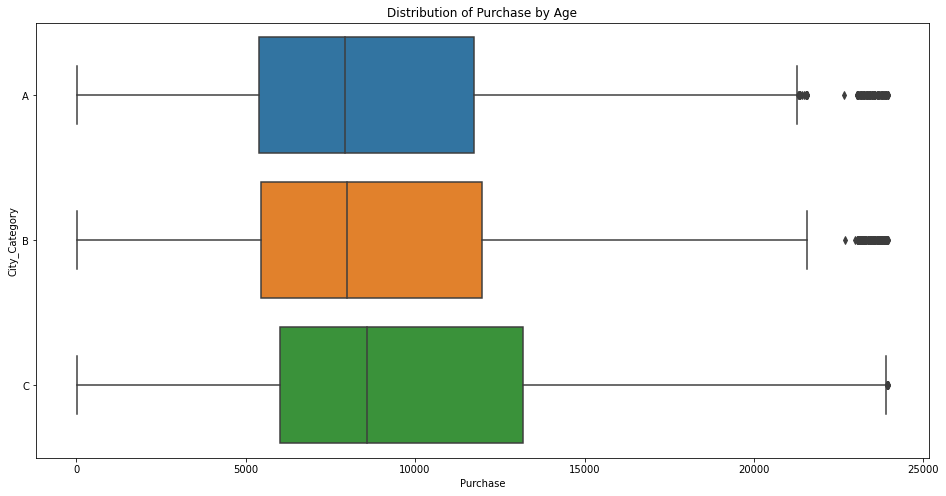

In [1528]:
plt.figure(figsize=(16, 8))

sns.boxplot(df_train['Purchase'], df_train['City_Category'], whis=1.5)

plt.xlabel('Purchase')
plt.ylabel('City_Category')
plt.title('Distribution of Purchase by Age')
plt.show()

По каждому из рассмотренных признаков можно сделать общий вывод, что распределение по всем значениям категорий в каждом признаке похоже. Медиана по признакам Age и Stay_In_Current_City_Yeas одинакова по всем значениям этих признаков. Значений Purchase свыше 22000 очевидно очень мало.

В признаке City_Category по городу C видно сдвиг вправо, в этом городе сумма покупок больше, нежели в других городах, а также бОльшее количество покупок на крупные суммы свыше 22000.

###  Разбиение на train и test

In [1529]:
X = df_train[feature_names]
y = df_train[target_name]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, shuffle = True, random_state = 42)

###  Обработка признаков и генерация новых фичей

In [1530]:
class DataPipeline():
    
    def fit(self, df):
        
        ''' Подготовка модели для заполнения пропусков'''
        
        fill_na = ['Product_Category_2', 'Product_Category_3']
        for el in fill_na:
            data = df.copy()
            features = ['Product_ID', 'Product_Category_1', el]
            data = data[features]
            target_col = el
            data['Product_ID'] = data['Product_ID'].map(lambda x: str(x)[1:]) 
            data['Product_ID'] = data['Product_ID'].astype(int)

            train = data[~data[target_col].isna()]

            X = train.drop(columns=target_col)
            y = train[target_col]

            X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                                test_size=0.2,
                                                                shuffle=True,
                                                                random_state=32)

            prod_cat_predictor = RandomForestRegressor(n_estimators=150,
                                          max_depth=15,
                                          random_state=42,
                                          verbose=1)
            prod_cat_predictor.fit(X_train, y_train)

            y_train_pred = prod_cat_predictor.predict(X_train)
            y_test_pred = prod_cat_predictor.predict(X_test)
            
            #Оценка точности модели по метрике r2:
            print(f"r2 на train {el}: {r2_score(y_train, y_train_pred)}")
            print(f"r2 на test {el}: {r2_score(y_test, y_test_pred)}")

        #сохранение модели для заполнения пропусков:
        with open('PROD_CAT_PREDICTOR', 'wb') as file:
            pickle.dump(prod_cat_predictor, file)
            
    def transform(self, df):
        
        ''' Подготовка модели для заполнения пропусков'''
        #1. Обработка признака Product_Category_2, 3. Заполнение пропусков
        
        #df['Product_Cat_2_Null'] = 0
        #df.loc[df['Product_Category_2'].isnull(), 'Product_Cat_2_Null'] = 1 <-- не показал себя в модели

        #Обработка признака Product_Category_3
        #df['Product_Cat_3_Null'] = 0
        #df.loc[df['Product_Category_3'].isnull(), 'Product_Cat_3_Null'] = 1  <-- не показал себя в модели
        
        #Обработка признака Product_ID
        
        df['Product_ID'] = df['Product_ID'].map(lambda x: str(x)[1:]) 
        df['Product_ID'] = df['Product_ID'].astype(int)
        
        #Заполним пропуски в Product_Category_2, Product_Category_3
        list_na = ['Product_Category_2', 'Product_Category_3']
        for el in list_na:
            data = df.copy()
            features = ['Product_ID', 'Product_Category_1', el]
            data = data[features]
            data = data[data[el].isna()]
            data.drop(el, axis = 1, inplace = True)
            data.columns
            with open('PROD_CAT_PREDICTOR', 'rb') as file:
                  prod_cat_predictor = pickle.load(file)
            data[el] = prod_cat_predictor.predict(data)
            df.loc[df[el].isna(), el] = list(data[el])

            #Корректировка типов
        df['Product_Category_2'] = df['Product_Category_2'].astype(int)
        df['Product_Category_3'] = df['Product_Category_3'].astype(int)
        
        #2. Обработка признаков - Генерация новых фичей

        ''' Gender - to dummies'''
        df = pd.concat([df, pd.get_dummies(df['Gender'])], axis = 1)
        df = df.drop('Gender', axis = 1)
        
        ''' Age - to categories'''
        #df = pd.concat([df, pd.get_dummies(df['Age'], prefix = 'Age')], axis = 1)
        #плохо показал себя в дамми
        
        df['age_cat'] = 0
        df.loc[df['Age'] == '0-17', 'age_cat'] = 1
        df.loc[df['Age'] == '18-25', 'age_cat'] = 2
        df.loc[df['Age'] == '26-35', 'age_cat'] = 3
        df.loc[df['Age'] == '36-45', 'age_cat'] = 4
        df.loc[df['Age'] == '46-50', 'age_cat'] = 5
        df.loc[df['Age'] == '50-55', 'age_cat'] = 6
        df.loc[df['Age'] == '55+', 'age_cat'] = 7
        df = df.drop('Age', axis = 1)
       
        ''' City_Category - to dummies '''
        
        df = pd.concat([df, pd.get_dummies(df['City_Category'])], axis = 1)
        df.rename(columns = {'A': 'City_Category_A', 'B': 'City_Category_B', 'C': 'City_Category_C'}, inplace = True)
        df = df.drop('City_Category', axis = 1)
        
        ''' Stay_In_Current_Years - to categories'''
        
        #df = pd.concat([df, pd.get_dummies(df['Stay_In_Current_City_Years'], prefix= 'Staying_')], axis = 1)
        #плохо показал себя в дамми
        
        df['stay_in_city_cat'] = 0
        df.loc[df['Stay_In_Current_City_Years'] == '0', 'stay_in_city_cat'] = 1
        df.loc[df['Stay_In_Current_City_Years'] == '1', 'stay_in_city_cat'] = 2
        df.loc[df['Stay_In_Current_City_Years'] == '2', 'stay_in_city_cat'] = 3
        df.loc[df['Stay_In_Current_City_Years'] == '3', 'stay_in_city_cat'] = 4
        df.loc[df['Stay_In_Current_City_Years'] == '4+', 'stay_in_city_cat'] = 5
        df = df.drop('Stay_In_Current_City_Years', axis = 1)
        
        return df

Так же были протестировано добавление в качестве признака метки кластера. Кластеризация была проведена с помощью визуальной оценки TSNE и метода DBSCAN. К сожалению, особо влияния на результат модели этот признак не оказал.

In [1531]:
pipe = DataPipeline()
pipe.fit(X_train)
X_train = pipe.transform(X_train)
X_test = pipe.transform(X_test)
df_test = pipe.transform(df_test)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    1.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


r2 на train Product_Category_2: 0.963697952342722
r2 на test Product_Category_2: 0.9601142179253538


[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


r2 на train Product_Category_3: 0.9874738781093357
r2 на test Product_Category_3: 0.9821038482577791


[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    0.1s finished


Проверим, остались ли пропуски

In [1532]:
X_train.isnull().sum() == X_test.isnull().sum()

User_ID               True
Product_ID            True
Occupation            True
Marital_Status        True
Product_Category_1    True
Product_Category_2    True
Product_Category_3    True
F                     True
M                     True
age_cat               True
City_Category_A       True
City_Category_B       True
City_Category_C       True
stay_in_city_cat      True
dtype: bool

In [1533]:
X_train.columns

Index(['User_ID', 'Product_ID', 'Occupation', 'Marital_Status',
       'Product_Category_1', 'Product_Category_2', 'Product_Category_3', 'F',
       'M', 'age_cat', 'City_Category_A', 'City_Category_B', 'City_Category_C',
       'stay_in_city_cat'],
      dtype='object')

In [1534]:
X_train.drop('User_ID', axis = 1, inplace = True)
X_test.drop('User_ID', axis = 1, inplace = True)

In [1535]:
def evaluate_preds(train_true_values, train_pred_values, test_true_values, test_pred_values):
    print("Train R2:\t" + str(round(r2_score(train_true_values, train_pred_values), 3)))
    print("Test R2:\t" + str(round(r2_score(test_true_values, test_pred_values), 3)))
    
    plt.figure(figsize=(18,10))
    
    plt.subplot(121)
    sns.scatterplot(x=train_pred_values, y=train_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Train sample prediction')
    
    plt.subplot(122)
    sns.scatterplot(x=test_pred_values, y=test_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Test sample prediction')

###   Построение моделей и выбор лучшей

####  Random Forest (Случайный лес)

Train R2:	0.72
Test R2:	0.698


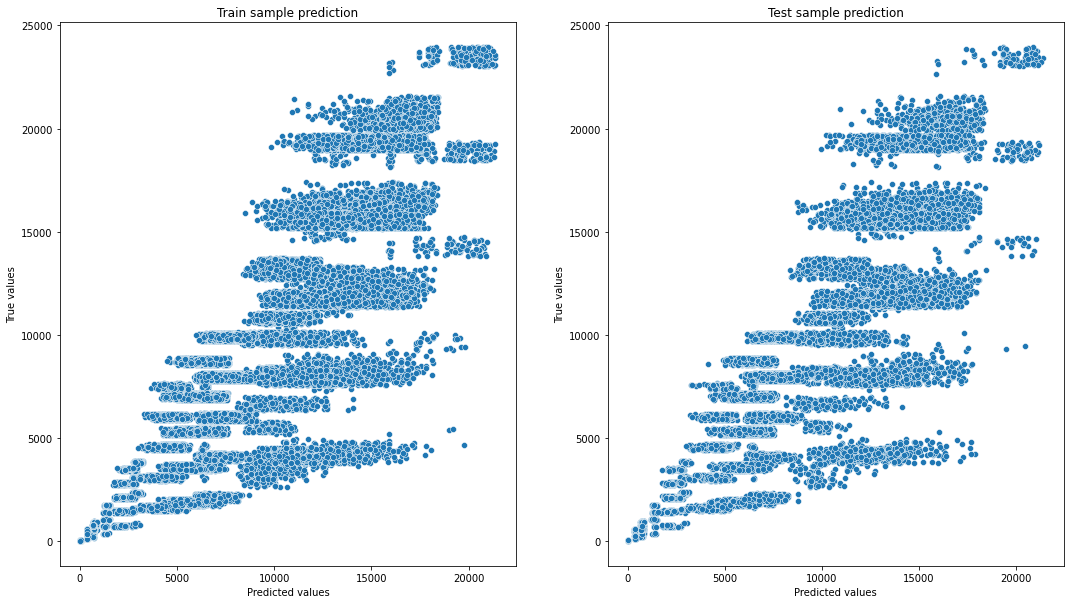

In [1536]:
rf_model = RandomForestRegressor(n_estimators = 200, max_depth = 20, min_samples_leaf = 30, random_state = 42)
rf_model.fit(X_train, y_train)

y_train_pred_rf = rf_model.predict(X_train)
y_test_pred_rf = rf_model.predict(X_test)

evaluate_preds(y_train, y_train_pred_rf, y_test, y_test_pred_rf)

####  Gradient Boosting (Градиентный бустинг)

Train R2:	0.749
Test R2:	0.708


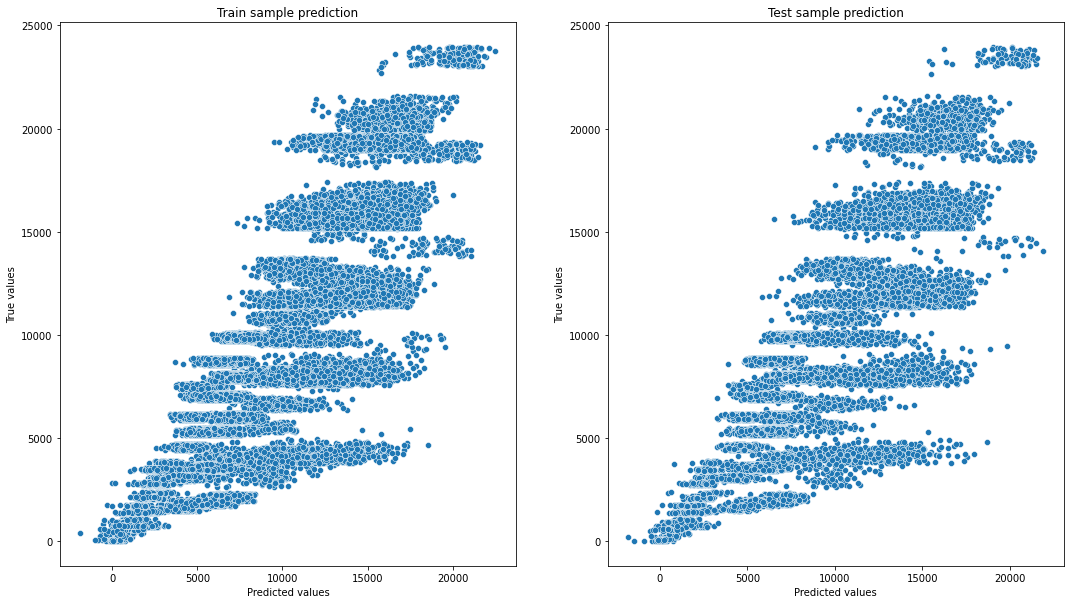

In [1537]:
#X_train.drop('cluster', axis = 1, inplace = True)
#X_test.drop('cluster', axis = 1, inplace = True)
gb_model = GradientBoostingRegressor(n_estimators = 350, max_depth = 6, min_samples_leaf = 20)
gb_model.fit(X_train, y_train)

y_train_pred_gb = gb_model.predict(X_train)
y_test_pred_gb = gb_model.predict(X_test)

evaluate_preds(y_train, y_train_pred_gb, y_test, y_test_pred_gb)

r2_gb_train = r2_score(y_train, y_train_pred_gb)
r2_gb_test = r2_score(y_test, y_test_pred_gb)


In [1538]:
feature_importances = pd.DataFrame(zip(X_train.columns, gb_model.feature_importances_), columns = ['feature_name', 'importance'])
feature_importances

,feature_name,importance
0,Product_ID,0.084568
1,Occupation,0.009862
2,Marital_Status,0.002222
3,Product_Category_1,0.851140
4,Product_Category_2,0.015125
5,Product_Category_3,0.013450
6,F,0.000918
7,M,0.001498
8,age_cat,0.006885
9,City_Category_A,0.002007


Вес признака Product_Category_1 превышает значимость остальных признаков в 10 раз, однако убрав его из модели, значение метрик ухудшилось

**Поскольку результаты на тесте выше всего на модели градиентного бустинга, продолжим развивать ее**

Подберем гиперпараметры:

In [1539]:
#parameters_gb = {'n_estimators': [250, 300, 350],
                 #'max_depth': [6, 7, 9],
                 #'min_samples_leaf': [10, 15, 17, 20]}

In [1540]:
#gs = GridSearchCV(estimator = GradientBoostingRegressor(),
                       #param_grid = parameters_gb,
                       #scoring = 'r2',
                       #cv = KFold(n_splits=5, random_state = 42, shuffle = True))

In [1541]:
#gs.fit(X_train, y_train)

In [1542]:
#gs.best_params_

#подбор гиперпараметров на кросс валидации дал : {'max_depth': 7, 'min_samples_leaf': 15, 'n_estimators': 300}

In [1543]:
#gs.best_score_

Train R2:	0.767
Test R2:	0.71


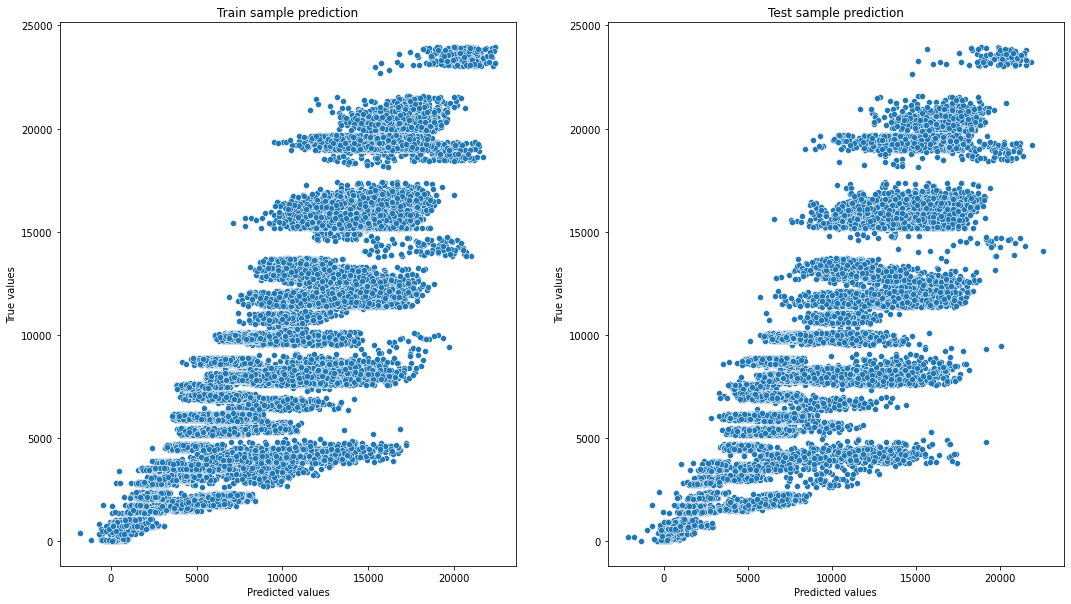

In [1544]:
gb_model_new = GradientBoostingRegressor(n_estimators = 300, max_depth = 7, min_samples_leaf = 15)
gb_model_new.fit(X_train, y_train)

y_train_pred_gb = gb_model_new.predict(X_train)
y_test_pred_gb = gb_model_new.predict(X_test)

evaluate_preds(y_train, y_train_pred_gb, y_test, y_test_pred_gb)

r2_gb_train = r2_score(y_train, y_train_pred_gb)
r2_gb_test = r2_score(y_test, y_test_pred_gb)

**Реализуем Бэггинг Бустингов**

Train R2:	0.76
Test R2:	0.711


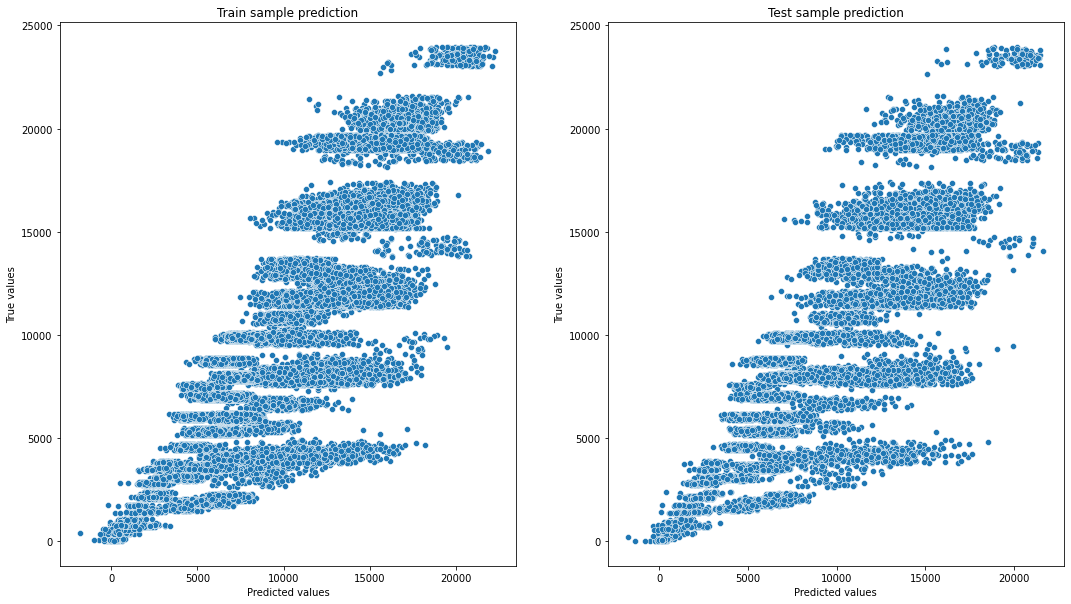

In [1545]:
br_model = BaggingRegressor(gb_model_new, n_estimators = 100, random_state = 42)
br_model.fit(X_train, y_train)

y_train_pred_br = br_model.predict(X_train)
y_test_pred_br = br_model.predict(X_test)

evaluate_preds(y_train, y_train_pred_br, y_test, y_test_pred_br)

In [1449]:
with open('BR_MODEL', 'wb') as file:
    pickle.dump(br_model, file)

Можно отметить небольшое снижение переобучения.

 **! предварительно я бы попробовала сделать прогноз на тестовых данных на моделях br_model**

##  Предсказание Purchase на тестовом датасете для соревнования на kaggle 

In [1450]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype
---  ------              --------------  -----
 0   User_ID             20000 non-null  int64
 1   Product_ID          20000 non-null  int64
 2   Occupation          20000 non-null  int64
 3   Marital_Status      20000 non-null  int64
 4   Product_Category_1  20000 non-null  int64
 5   Product_Category_2  20000 non-null  int64
 6   Product_Category_3  20000 non-null  int64
 7   F                   20000 non-null  uint8
 8   M                   20000 non-null  uint8
 9   age_cat             20000 non-null  int64
 10  City_Category_A     20000 non-null  uint8
 11  City_Category_B     20000 non-null  uint8
 12  City_Category_C     20000 non-null  uint8
 13  stay_in_city_cat    20000 non-null  int64
dtypes: int64(9), uint8(5)
memory usage: 1.5 MB


In [1451]:
df_test.drop('User_ID', axis = 1, inplace = True)

In [1456]:
df_test.columns

Index(['Product_ID', 'Occupation', 'Marital_Status', 'Product_Category_1',
       'Product_Category_2', 'Product_Category_3', 'F', 'M', 'age_cat',
       'City_Category_A', 'City_Category_B', 'City_Category_C',
       'stay_in_city_cat'],
      dtype='object')

In [1457]:
final_model = br_model

In [1458]:
predictions = final_model.predict(df_test)
#лучшую из моделей выберем в качестве final

In [1459]:
submit = pd.read_csv('sample_submission.csv')

In [1460]:
submit.columns
submit['Purchase'].head()

0    9000
1    9000
2    9000
3    9000
4    9000
Name: Purchase, dtype: int64

In [1461]:
submit['Purchase'] = predictions

In [1462]:
submit[['Id', 'Purchase']].to_csv('Course_Proj_AViatkina_br_model.csv', index=None)

In [1463]:
submit['Purchase'].shape

(20000,)

In [1546]:
submit['Purchase'].head()

0     7032.549774
1     8316.257645
2    10357.193051
3     7370.035583
4     7158.115478
Name: Purchase, dtype: float64